In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance
import matplotlib.pyplot as plt
import gc
from ggplot import *

path = '/home/icervera/workspace-python/kaggle/AdTracking/data/'

print('loading train data...')

start_time = time.time()

train_df = pd.read_csv(path+"train10000000_newFeatures.csv", nrows=10000000)

print('[{}] Finished to load data'.format(time.time() - start_time))
train_df.shape

/home/icervera/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/icervera/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/icervera/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/icervera/anaconda3/lib/python3.6/site-pack

loading train data...
[58.61815619468689] Finished to load data


(10000000, 33)

In [2]:
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df.head()

,ip,app,device,os,channel,is_attributed,day,hour,clicks_by_ipDay,clicks_by_ip,...,ClickOnThisAppBefore_byDay,NbrClick_byDayByIP,NbrClick_byDayByIP_log,app_byIP,app_byChannel,click_byChannel,channel_byIP,clicks_by_ip_log,channel_byIP_log,ratio_byChannel
0,9,18,1,13,107,0,6,16.041667,154,167,...,False,154,5.036952,19,4,388035,43,5.117994,3.7612,97008.750000
1,9,18,1,13,107,0,6,16.044722,154,167,...,True,154,5.036952,19,4,388035,43,5.117994,3.7612,97008.750000
2,9,18,1,13,107,0,6,16.415000,154,167,...,True,154,5.036952,19,4,388035,43,5.117994,3.7612,97008.750000
3,9,12,1,13,178,0,6,16.491389,154,167,...,False,154,5.036952,19,3,269720,43,5.117994,3.7612,89906.666667
4,9,12,1,13,178,0,6,16.491389,154,167,...,True,154,5.036952,19,3,269720,43,5.117994,3.7612,89906.666667


In [3]:
list(train_df)

['ip',
 'app',
 'device',
 'os',
 'channel',
 'is_attributed',
 'day',
 'hour',
 'clicks_by_ipDay',
 'clicks_by_ip',
 'click_interval',
 'hour_byIP_08quantile',
 'hour_byIP_byDay_08quantile',
 'hour_byIP_02quantile',
 'click_interval_median',
 'click_interval_08quantile',
 'click_interval_02quantile',
 'click_interval_dist',
 'NbrClickOnThisAppBefore_byDay',
 'NbrClickBefore_byDay',
 'ratio_NbrClickOnThisAppBefore_byDay',
 'click_interval_log',
 'ClickOnThisAppBefore_byDay',
 'NbrClick_byDayByIP',
 'NbrClick_byDayByIP_log',
 'app_byIP',
 'app_byChannel',
 'click_byChannel',
 'channel_byIP',
 'clicks_by_ip_log',
 'channel_byIP_log',
 'ratio_byChannel']

In [4]:
train_df['multiple_click'] =np.log(train_df['ratio_byChannel']*train_df['NbrClick_byDayByIP'])
train_df['multiple_click_plus'] =np.log(train_df['ratio_byChannel']*train_df['NbrClick_byDayByIP']/train_df['channel_byIP'])
train_df['ratio_byChannel_log'] =np.log(train_df['ratio_byChannel'])
# train_df =train_df.drop(['channel_byIP_log'], axis=1)

train_df['ratio_NbrClickOnThisAppBefore_byDay_v2'] = (train_df['NbrClickBefore_byDay']-train_df['NbrClickOnThisAppBefore_byDay'])/(train_df['NbrClickBefore_byDay']+1)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(10, whiten=True)

pca_train_df = train_df.drop(['ip',
                              'app',
                              'hour_byIP_08quantile','hour_byIP_02quantile',
                              'device','os','channel','is_attributed','ClickOnThisAppBefore_byDay',
                             'clicks_by_ip_log','click_interval_log',
                              'click_interval_median','click_interval_08quantile','click_interval_02quantile',
                              'NbrClickBefore_byDay',
                              'NbrClickOnThisAppBefore_byDay',
                              #'ratio_NbrClickOnThisAppBefore_byDay',
                             'clicks_by_ipDay','clicks_by_ip',
                              #'NbrClick_byDayByIP_log',
                              'ratio_byChannel',
                              'NbrClick_byDayByIP',
                              #'click_byChannel',
                              'day', 'hour','hour_byIP_byDay_08quantile',
                             'click_interval_dist'], axis=1)

pca_train_df.head()

,click_interval,ratio_NbrClickOnThisAppBefore_byDay,NbrClick_byDayByIP_log,app_byIP,app_byChannel,click_byChannel,channel_byIP,channel_byIP_log,multiple_click,multiple_click_plus,ratio_byChannel_log,ratio_NbrClickOnThisAppBefore_byDay_v2
0,24.000000,0.000000,5.036952,19,4,388035,43,3.7612,16.519509,12.758309,11.482556,0.00
1,0.003056,0.500000,5.036952,19,4,388035,43,3.7612,16.519509,12.758309,11.482556,0.00
2,0.370278,0.666667,5.036952,19,4,388035,43,3.7612,16.519509,12.758309,11.482556,0.00
3,0.076389,0.000000,5.036952,19,3,269720,43,3.7612,16.443480,12.682280,11.406527,0.75
4,0.000000,0.200000,5.036952,19,3,269720,43,3.7612,16.443480,12.682280,11.406527,0.60


In [6]:
from sklearn.preprocessing import StandardScaler
pca_train_df_std = StandardScaler().fit_transform(pca_train_df)

Y = pca.fit_transform(pca_train_df_std)
pca_df = pd.DataFrame.from_records(Y, columns=['PC{}'.format(i + 1) for i in range(pca.n_components_)])

pca_df = pd.concat([pca_df, train_df], axis=1)

loadings = pca.components_
loadings_df = pd.DataFrame.from_records(loadings)
loadings_df.columns = pca_train_df.columns
loadings_df


,click_interval,ratio_NbrClickOnThisAppBefore_byDay,NbrClick_byDayByIP_log,app_byIP,app_byChannel,click_byChannel,channel_byIP,channel_byIP_log,multiple_click,multiple_click_plus,ratio_byChannel_log,ratio_NbrClickOnThisAppBefore_byDay_v2
0,0.120579,-0.001819,-0.414962,-0.372992,0.068403,-0.117321,-0.395298,-0.358625,-0.424794,-0.382714,-0.155242,-0.140732
1,-0.102337,-0.316094,0.107314,0.174419,0.271042,-0.425976,0.213575,0.226122,-0.183591,-0.279748,-0.520055,0.337028
2,0.333741,0.510944,0.177077,0.176767,0.219054,-0.247213,0.140396,0.046272,0.004300,-0.008919,-0.271600,-0.600112
3,0.808081,-0.537113,-0.027619,0.117183,0.044596,0.165899,0.077506,0.002413,0.016042,0.017792,0.074266,-0.049045
4,-0.123093,0.023511,0.026890,0.000025,0.850959,0.490838,-0.055299,-0.099902,0.017390,0.050045,-0.009293,0.050870
5,0.010938,-0.123874,0.294568,0.147548,0.057663,-0.339171,-0.310390,-0.660574,0.178080,0.403733,-0.125502,0.120289
6,-0.178480,-0.025721,-0.166544,0.742221,-0.236170,0.356475,0.048098,-0.288676,-0.223274,-0.171100,-0.163071,-0.120989
7,0.094848,0.075292,0.390286,-0.345544,-0.297623,0.482101,-0.015224,-0.040354,-0.000478,0.011555,-0.617627,0.095674
8,-0.357077,-0.491721,0.040586,-0.269831,0.002266,-0.013281,0.417444,-0.193891,0.014850,0.075312,-0.035784,-0.580553
9,0.164265,0.294125,-0.169993,-0.143546,0.008203,-0.022634,0.704416,-0.444470,-0.099073,0.018999,0.079483,0.355212


In [28]:
#rdm_pca_df = pca_df.sample(100000, axis=0) # for the plot
#tpm_pca_df = rdm_pca_df.loc[rdm_pca_df['is_attributed']==1]
#tpm2_pca_df = rdm_pca_df.loc[rdm_pca_df['is_attributed']!=1]
#gc.collect()
tpm_pca_df['click_interval']

556         0.000000
1412       24.000000
4971        2.610556
4990       24.000000
5336        0.006667
5473        0.007222
6239        0.107778
6353        0.004167
7219        0.045278
7753        0.118611
7808        0.005000
8608        0.591389
8990        0.105556
10555       0.042778
10558       0.101667
13373       0.012500
13395       0.030000
13627       0.452500
13693       0.005556
14083       0.000556
14195       0.296389
15798       0.317778
16140       0.001111
16509       0.073889
18595       0.139722
19390       0.998889
19521       0.001111
20145       0.000833
24593      24.000000
24741      24.000000
             ...    
9992306    24.000000
9992394     3.893056
9992523    24.000000
9993295     0.000833
9994055    24.000000
9994057     0.687778
9994362     3.048333
9994392    24.000000
9994407     0.013056
9994414     0.000278
9994416    24.000000
9994645     0.000000
9994646    24.000000
9994678     0.010278
9994679    24.000000
9994751    24.000000
9995918     0

In [32]:
tpm_pca_df = pca_df.loc[pca_df['is_attributed']==1]
tpm_pca_df.assign(is_attributed = lambda x: pd.Series(np.repeat(1, x.shape[0]), index=x.index)) 
tpm2_pca_df = pca_df.loc[pca_df['is_attributed']!=1].sample(18000, axis=0)
tpm2_pca_df.assign(is_attributed = lambda x: pd.Series(np.repeat(0, x.shape[0]), index=x.index)) 
rdm_pca_df = pd.concat([tpm_pca_df,tpm2_pca_df])

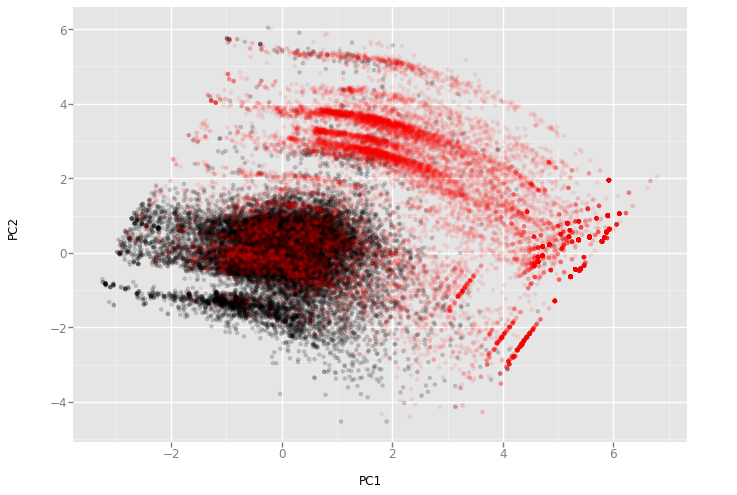

<ggplot: (8755616076580)>


In [8]:

# PC2 PC5 et PC9 sont interessantes sans le feature ratio_byChannel
# PC2=click_byChannel et 4=app_byChannel
PC_x = 'PC1'
PC_y = 'PC2'

gg_plot = ggplot( aes(PC_x, PC_y), data=tpm2_pca_df) +\
    geom_point(alpha=0.2) +\
    geom_point( aes(PC_x, PC_y),color='red', data=tpm_pca_df,alpha=0.1)
print(gg_plot)


In [37]:
center_pca_df['is_attributed']

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
10614    0
10615    0
10616    0
10617    0
10618    0
10619    0
10620    0
10621    0
10622    0
10623    0
10624    0
10625    0
10626    0
10627    0
10628    0
10629    0
10630    0
10631    0
10632    0
10633    0
10634    0
10635    0
10636    0
10637    0
10638    0
10639    0
10640    0
10641    0
10642    0
10643    0
Name: is_attributed, Length: 10644, dtype: int64

In [33]:
center_pca_df = rdm_pca_df[(rdm_pca_df['PC1']>(-1)) & (rdm_pca_df['PC1']<1) & 
                          (rdm_pca_df['PC2']>(-0.5)) & (rdm_pca_df['PC2']<(1))]
#gg_plot = ggplot( aes(PC_x, PC_y), data=center_pca_df) +\
#    geom_point(alpha=0.5) 
#print(gg_plot)
center_pca_df = center_pca_df.reset_index(drop=True)
center_pca_df.head()
center_pca_df.shape

(10644, 46)

In [38]:
from sklearn.decomposition import PCA
pca = PCA(10, whiten=True)

pca_train_df2 = center_pca_df.drop(['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
                                   'ip',
                                  'app',
                                  'hour_byIP_08quantile','hour_byIP_02quantile',
                                  'device','os','channel','is_attributed','ClickOnThisAppBefore_byDay',
                                  'clicks_by_ip_log','click_interval_log',
                                  'click_interval_median','click_interval_08quantile','click_interval_02quantile',
                                  'NbrClickBefore_byDay',
                                  'NbrClickOnThisAppBefore_byDay',
                                  #'ratio_NbrClickOnThisAppBefore_byDay',
                                 'clicks_by_ipDay','clicks_by_ip',
                                  #'NbrClick_byDayByIP_log',
                                  'ratio_byChannel',
                                  'NbrClick_byDayByIP',
                                  #'click_byChannel',
                                  'day', 'hour','hour_byIP_byDay_08quantile',
                                 'click_interval_dist'], axis=1)

pca_train_df2.head()

,click_interval,ratio_NbrClickOnThisAppBefore_byDay,NbrClick_byDayByIP_log,app_byIP,app_byChannel,click_byChannel,channel_byIP,channel_byIP_log,multiple_click,multiple_click_plus,ratio_byChannel_log,ratio_NbrClickOnThisAppBefore_byDay_v2
0,0.001111,0.122222,5.424950,19,1,60869,60,4.094345,16.441429,12.347085,11.016479,0.872222
1,0.001111,0.123596,4.615120,18,1,60869,45,3.806662,15.631600,11.824937,11.016479,0.865169
2,0.050556,0.008850,5.451038,25,2,402226,55,4.007333,17.662661,13.655327,12.211622,0.986726
3,0.000000,0.022472,6.276643,29,5,469845,73,4.290459,17.727364,13.436904,11.450720,0.966292
4,0.000556,0.029478,7.332369,29,1,61366,79,4.369448,18.356980,13.987533,11.024611,0.969766


In [39]:
from sklearn.preprocessing import StandardScaler
pca_train_df_std2 = StandardScaler().fit_transform(pca_train_df2)

Y2 = pca.fit_transform(pca_train_df_std2)
pca_df2 = pd.DataFrame.from_records(Y2, columns=['PC{}'.format(i + 1) for i in range(pca.n_components_)])

#pca_df2 = pd.concat([pca_df2, train_df], axis=1)

loadings2 = pca.components_
loadings_df2 = pd.DataFrame.from_records(loadings2)
loadings_df2.columns = pca_train_df2.columns
loadings_df2

,click_interval,ratio_NbrClickOnThisAppBefore_byDay,NbrClick_byDayByIP_log,app_byIP,app_byChannel,click_byChannel,channel_byIP,channel_byIP_log,multiple_click,multiple_click_plus,ratio_byChannel_log,ratio_NbrClickOnThisAppBefore_byDay_v2
0,0.070392,-0.024612,-0.404343,-0.384435,-0.007502,-0.105745,-0.407761,-0.398460,-0.423236,-0.387936,-0.120380,-0.052583
1,-0.033791,0.479899,0.111732,0.140527,-0.240693,-0.491950,0.137522,0.136010,-0.097283,-0.144857,-0.404089,-0.453022
2,0.131646,0.430430,-0.098117,-0.168037,-0.262278,0.244574,-0.159998,-0.161721,0.175259,0.240582,0.538235,-0.448202
3,-0.110626,0.268733,-0.084407,0.093045,0.727538,0.435499,0.098162,0.106996,-0.127369,-0.172265,-0.104784,-0.320671
4,0.980263,0.001329,0.061371,0.052841,0.131410,-0.005400,0.045658,0.042934,0.004012,-0.005903,-0.104679,0.017012
5,-0.057267,0.129714,0.465987,-0.301061,0.293398,-0.098453,-0.337421,-0.369446,0.250846,0.378102,-0.344917,0.033796
6,-0.005139,-0.119178,-0.044234,0.818607,0.010389,-0.018215,-0.296035,-0.452353,-0.033957,0.071733,0.012030,-0.120634
7,0.004771,-0.692985,0.088010,-0.155419,0.018548,-0.048974,0.043771,0.053126,0.061251,0.057253,-0.036820,-0.687010
8,0.009477,-0.017521,0.176836,0.011016,-0.489992,0.696288,-0.030246,-0.027597,-0.075277,-0.079587,-0.478900,-0.016702
9,-0.000332,0.006190,-0.059202,-0.088003,-0.003826,0.007602,0.757086,-0.635662,-0.064998,0.080982,-0.023812,0.006745


In [89]:
#rdm_pca_df2 = pca_df2.sample(50000, axis=0) # for the plot
#tpm_pca_df2 = pca_df2.loc[pca_df2['is_attributed']==1]
#tpm2_pca_df2 = pca_df2.loc[pca_df2['is_attributed']!=1]
gc.collect()

tpm_pca_df2 = pca_df2.loc[center_pca_df['is_attributed']==1]
tpm2_pca_df2 = pca_df2.loc[center_pca_df['is_attributed']!=1]
rdm_pca_df2 = pd.concat([tpm_pca_df2,tpm2_pca_df2])

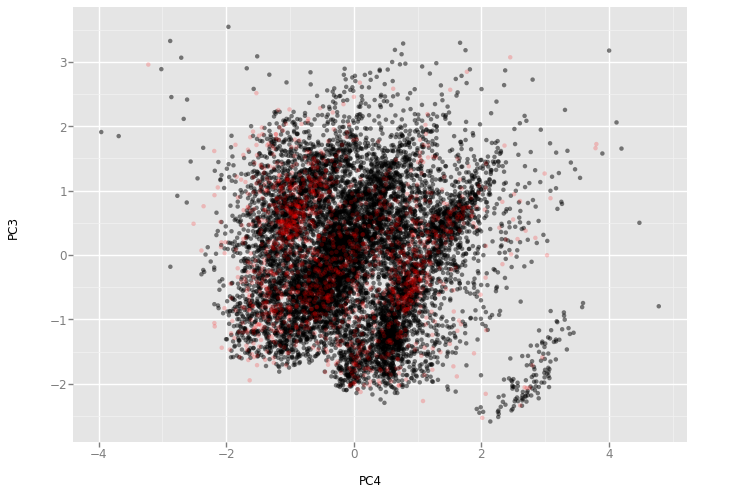

<ggplot: (-9223363281298930281)>


In [78]:

# PC2 PC5 et PC9 sont interessantes sans le feature ratio_byChannel
# PC2=click_byChannel et 4=app_byChannel
PC_x = 'PC4'
PC_y = 'PC3'

gg_plot = ggplot( aes(PC_x, PC_y), data=tpm2_pca_df2) +\
    geom_point(alpha=0.5) +\
    geom_point( aes(PC_x, PC_y),color='red', data=tpm_pca_df2,alpha=0.2)
print(gg_plot)


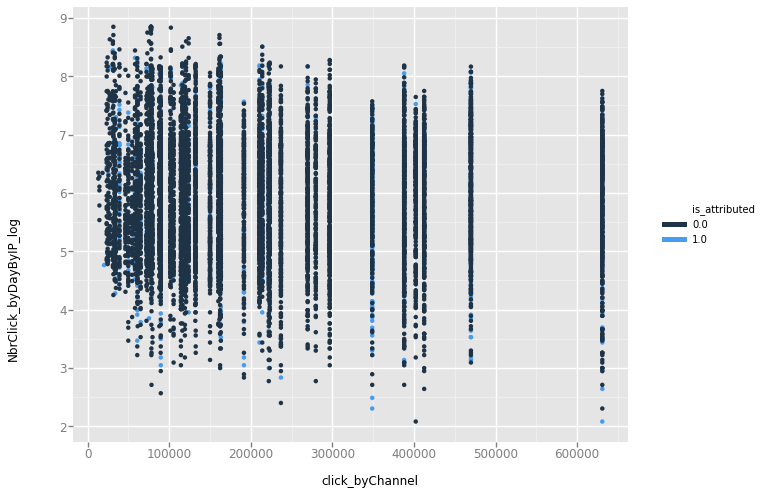

<ggplot: (8755553136581)>


In [131]:
ska_df = center_pca_df.drop(['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'], axis=1)
rdm_pca_df2 = pd.concat([pca_df2, ska_df],axis=1)
rdm_pca_df2.head()

gg_plot = ggplot( aes('click_byChannel', 'NbrClick_byDayByIP_log', color="is_attributed"), data=rdm_pca_df2) +\
    geom_point(alpha=1)
print(gg_plot)
